Python sources: https://github.com/MatrixNorm/kaggle/tree/master/python_sources/kaggle/house_prices


Original R notebook: https://nbviewer.jupyter.org/github/MatrixNorm/kaggle/blob/master/rbooks/house_prices/01_first_look.ipynb

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext rpy2.ipython

In [20]:
import numpy as np
import pandas as pd
import kaggle.house_prices.notebook as book
from kaggle.house_prices.notebook import ggplot2 as gg2

book.inject_css()

# Fixing rpy2 library

Library rpy2 needs a fix:
* https://bitbucket.org/rpy2/rpy2/issues/398/pandas2ri-conversion-does-not-work-for    
* https://bitbucket.org/rpy2/rpy2/commits/6507a43d2793
   
```
- res.rclass = StrSexpVector('ordered', 'factor')
+ res.rclass = StrSexpVector(('ordered', 'factor'))

```

In [3]:
from rpy2 import robjects

# should be no error
category = pd.Series(pd.Categorical(['a','b','c','a'],
                     categories=['a','b','c'],
                     ordered=True))
robjects.conversion.py2ro(category)

a,b,c,a


# Remark #1: Group by and missing values

Dplyr's grouping&summarising does not throw away NA group, while in pandas it do.

Workaround is it to fill NA values with some designated value like `__missing__` or whatever.

In [4]:
%%R

library(dplyr, warn.conflicts=FALSE)

df <- tribble(
    ~categ, ~numer,
     'a',    1,
     'a',    2,
     'b',    3,
     NA,     4,
     NA,     5
)

# in dplyr NA is treated as a group
df %>% 
group_by(categ) %>% 
summarise(mean = mean(numer))

# A tibble: 3 x 2
  categ  mean
  <chr> <dbl>
1     a   1.5
2     b   3.0
3  <NA>   4.5


In [6]:
df = pd.DataFrame(
    [
        ('a',    1),
        ('a',    2),
        ('b',    3),
        (np.NaN, 4),
        (np.NaN,    5)
    ], 
    columns=['categ', 'numer']
)

# not in Python
book.show_table(
    df.groupby('categ').agg({'numer': np.mean}).reset_index(), 
    df.fillna('__missing__').groupby('categ').agg({'numer': np.mean}).reset_index()
)

,categ,numer
0,a,1.5
1,b,3.0
,categ,numer
0,__missing__,4.5
1,a,1.5
2,b,3.0


In [9]:
import kaggle.house_prices.helpers as helpers
from kaggle.house_prices import attributes_selection as attr_sel

# load data
combined_dataset = helpers.load_data()

book.HTML("".join([
    book.show_list_html(
        combined_dataset.shape, 
        cap="combined"
    ),
    book.show_list_html(
        combined_dataset[combined_dataset['dataSource'] == 'train'].shape, 
        cap="train"
    ),
    book.show_list_html(
        combined_dataset[combined_dataset['dataSource'] == 'test'].shape, 
        cap="test"
    ),
]))

In [11]:
character_colnames = helpers.get_character_colnames(combined_dataset)
numeric_colnames = helpers.get_numeric_colnames(combined_dataset)

book.show_list(character_colnames, cap="Categorical predictors")
book.show_list(numeric_colnames, cap="Numeric predictors")

In [13]:
# replace NA in categorical columns with `__missing__`
# see remark #1 about NAs in pandas
categ_data = (
    combined_dataset
    [helpers.get_character_colnames(combined_dataset)]
    .fillna('__missing__')
    .assign(
        SalePrice=combined_dataset['SalePrice'],
        Id=combined_dataset['Id']
    )
)

numeric_data = (
    combined_dataset
    [helpers.get_numeric_colnames(combined_dataset)]
    .assign(
        Id=combined_dataset['Id']
    )
)

book.HTML("".join([
    book.show_list_html(categ_data.shape, cap="categ"),
    book.show_list_html(numeric_data.shape, cap="numeric")
]))

# "Normal Paper" applied to SalePrice

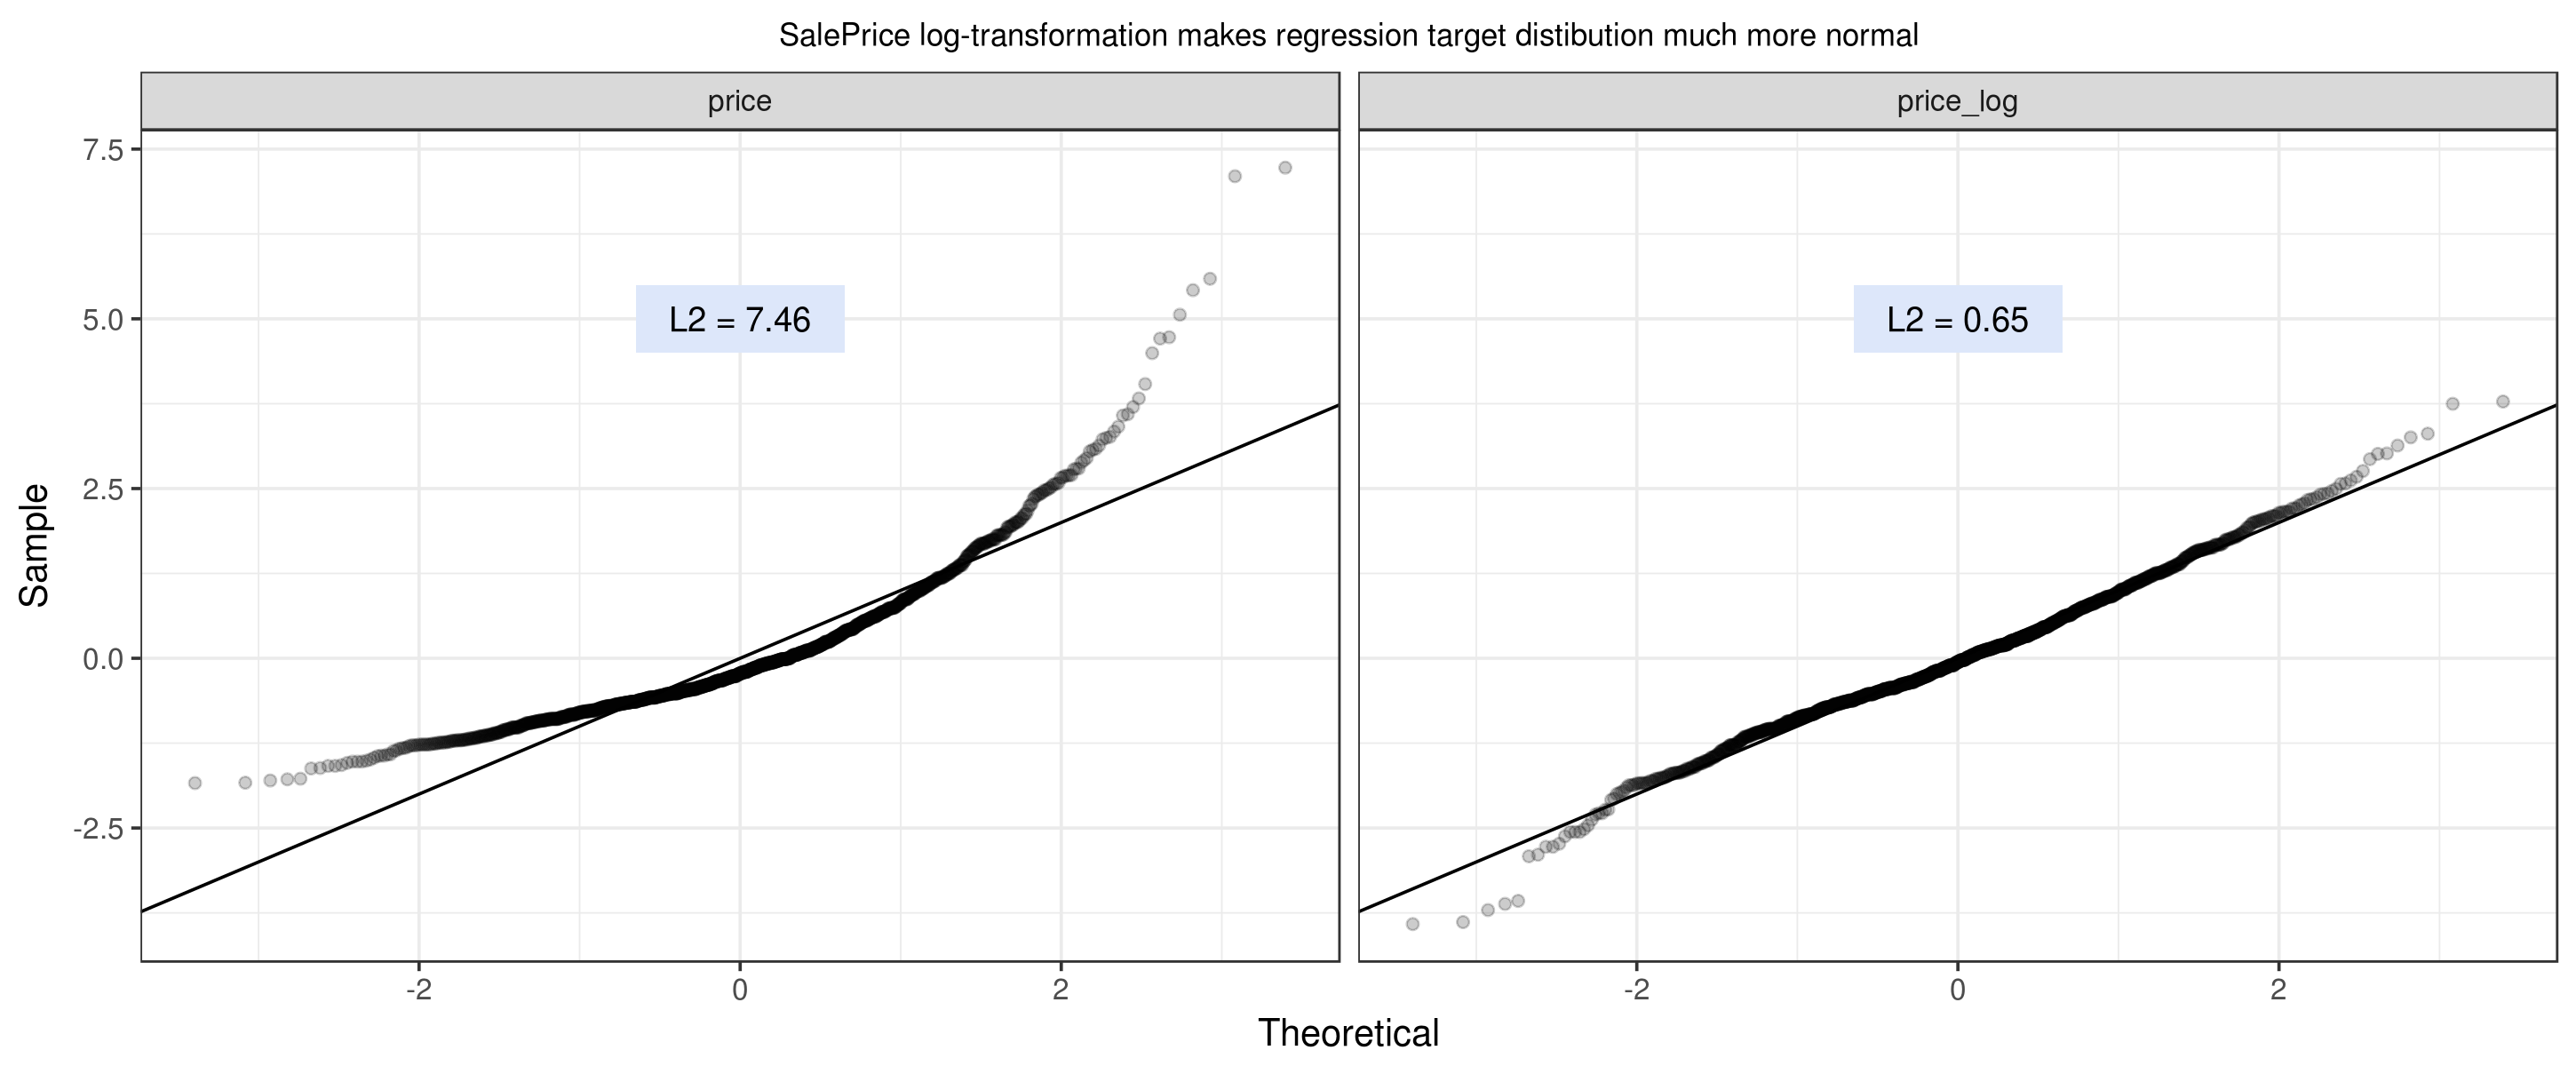

In [21]:
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF

target_normal_paper = pd.melt(
    (
        combined_dataset
        [['SalePrice']]
        .dropna()
        .rename(
            columns={"SalePrice": "price"}
        )
        .assign(
            price_log = lambda df: np.log(df['price'])
        )
    ), 
    var_name='var', 
    value_name='value'
).assign(
    normed_value = lambda df: (
        df
        .groupby('var', group_keys=False)
        .apply(
            lambda gr: (gr.value - np.mean(gr.value)) / np.std(gr.value, ddof=1)
        )
    )
)

# Deviation from theoretical normal distribution in terms of L2 norm
def calc_L2_distance(gr):
    nval = gr['normed_value'].sort_values()
    ecdf = ECDF(nval)
    empir = ecdf(nval)
    theor = stats.norm.cdf(nval)
    L2_delta = np.sum((empir - theor)**2)
    return round(L2_delta, 2)


L2_labels = (
   target_normal_paper
   .drop(columns=['value'])
   .groupby(['var'])
   .apply(calc_L2_distance)
   .to_frame('L2')
   .reset_index()
   .assign(
       x=0,
       y=5,
       lab=lambda df: (
           df['L2']
           .apply(lambda x: 'L2 = {}'.format(x))
       )
   )
)

book.show_table(
    (target_normal_paper
        .sort_values(['var', 'value'])
        .groupby('var')
        .tail(1)
    ),
    L2_labels
)

with book.Plot(width=2900, height=1200, res=250) as plot:
    plot(
        gg2.ggplot(target_normal_paper) +
        gg2.stat_qq(gg2.aes_string(sample='normed_value'), alpha=0.2) +
        gg2.facet_wrap(book.robjects.Formula('~var'), ncol=2) +
        gg2.geom_abline(slope=1) +
        gg2.theme_bw() +
        gg2.theme(**{
            'legend.position': "bottom", 
            'plot.title': gg2.element_text(hjust = 0.5)
        }) +
        gg2.labs(
            title="""SalePrice log-transformation makes regression target distibution much more normal"""
        ) +
        gg2.labs(x="Theoretical") + gg2.labs(y="Sample") +
        gg2.geom_rect(
            gg2.aes_string(xmin=-0.65, xmax=0.65, ymin=4.5, ymax=5.5), 
            fill='#dde7fa'
        ) +
        gg2.geom_text(gg2.aes_string(x='x', y='y', label='lab'), data=L2_labels)        
    )

# Entropy of attribute distributions

,var,entropy,type,basket
74,TotalBsmtSF,9.348757,Numeric,4.0
75,BsmtUnfSF,9.390885,Numeric,4.0
76,X1stFlrSF,9.601608,Numeric,4.0
77,GrLivArea,9.882939,Numeric,4.0
78,LotArea,10.400602,Numeric,4.0
,var,entropy,type,basket
0,Utilities,0.012627,Categorical,1.0
1,PoolQC,0.038203,Categorical,1.0
2,Street,0.038504,Categorical,1.0
3,PoolArea,0.057677,Numeric,1.0


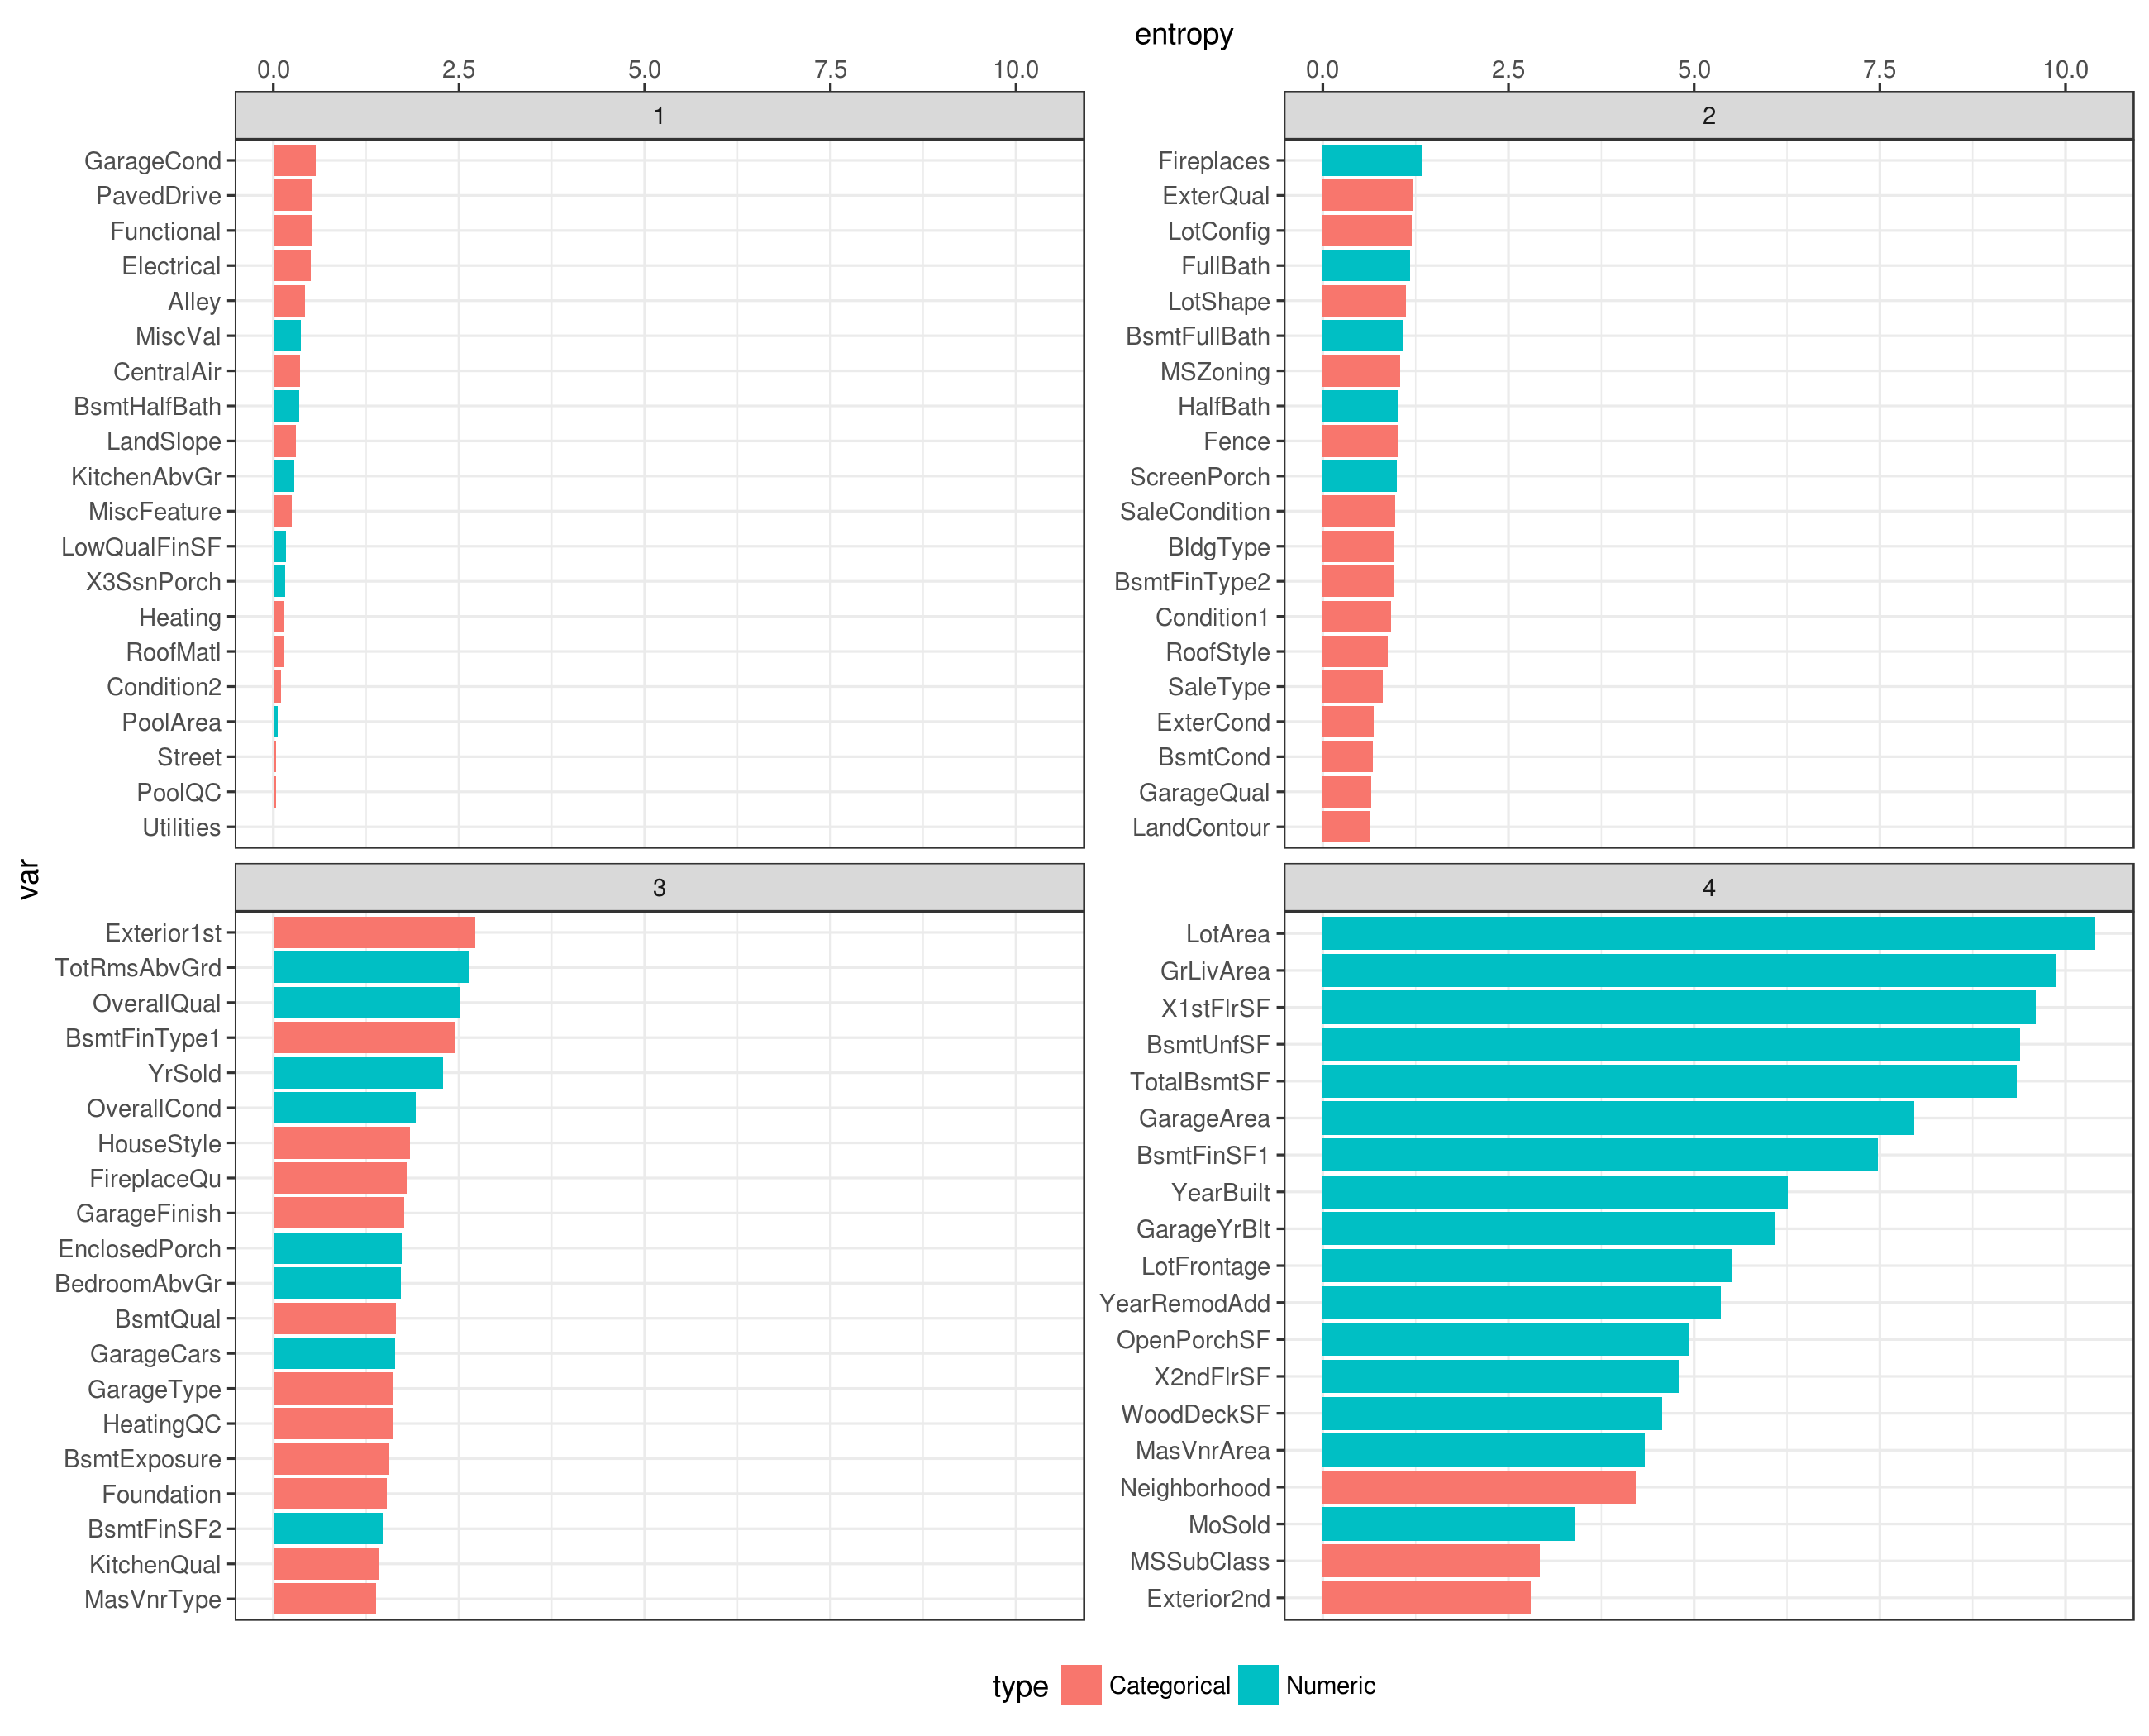

In [29]:
predictors_by_entropy = (
    pd.concat([
        attr_sel.arrange_vars_by_entropy(
            numeric_data.drop(columns=["SalePrice", "Id"])
        ).assign(type="Numeric"),

        attr_sel.arrange_vars_by_entropy(
            categ_data.drop(columns=["SalePrice", "Id"])
        ).assign(type="Categorical")
    ])
    .sort_values('entropy')
    .reset_index(drop=True)
    .assign(
        var=lambda df: (
            df['var'].astype('category')
            .cat.reorder_categories(df['var'], ordered=True)
        ),
        basket=lambda df: (
            np.floor(4*(df.index / df.shape[0])) + 1
        )
    )    
)

book.show_table(
    (predictors_by_entropy.tail(), 'Large entropy'),
    (predictors_by_entropy.head(), 'Small entropy'), 
)

with book.Plot(width=2600, height=2100, res=220) as plot:
    plot(
        gg2.ggplot(data=predictors_by_entropy) +
        gg2.geom_bar(gg2.aes_string(x='var', y='entropy', fill='type'), stat="identity") +
        gg2.facet_wrap(book.robjects.Formula('~basket'), nrow = 2, ncol = 2, scales="free_y") +
        gg2.coord_flip() +
        gg2.scale_y_continuous(position="top") +
        gg2.theme_bw() +
        gg2.theme(**{'legend.position': "bottom"}) 
    )

# Separation between groups

,var,score,type,basket
39,BsmtFinType1,0.137713,Categorical,2.0
40,GarageFinish,0.318138,Categorical,2.0
41,BsmtQual,0.491327,Categorical,2.0
42,KitchenQual,0.545586,Categorical,2.0
43,ExterQual,0.663814,Categorical,2.0
,var,score,type,basket
0,Utilities,0.000159,Categorical,1.0
1,LandSlope,0.000642,Categorical,1.0
2,RoofMatl,0.000978,Categorical,1.0
3,Condition2,0.001084,Categorical,1.0


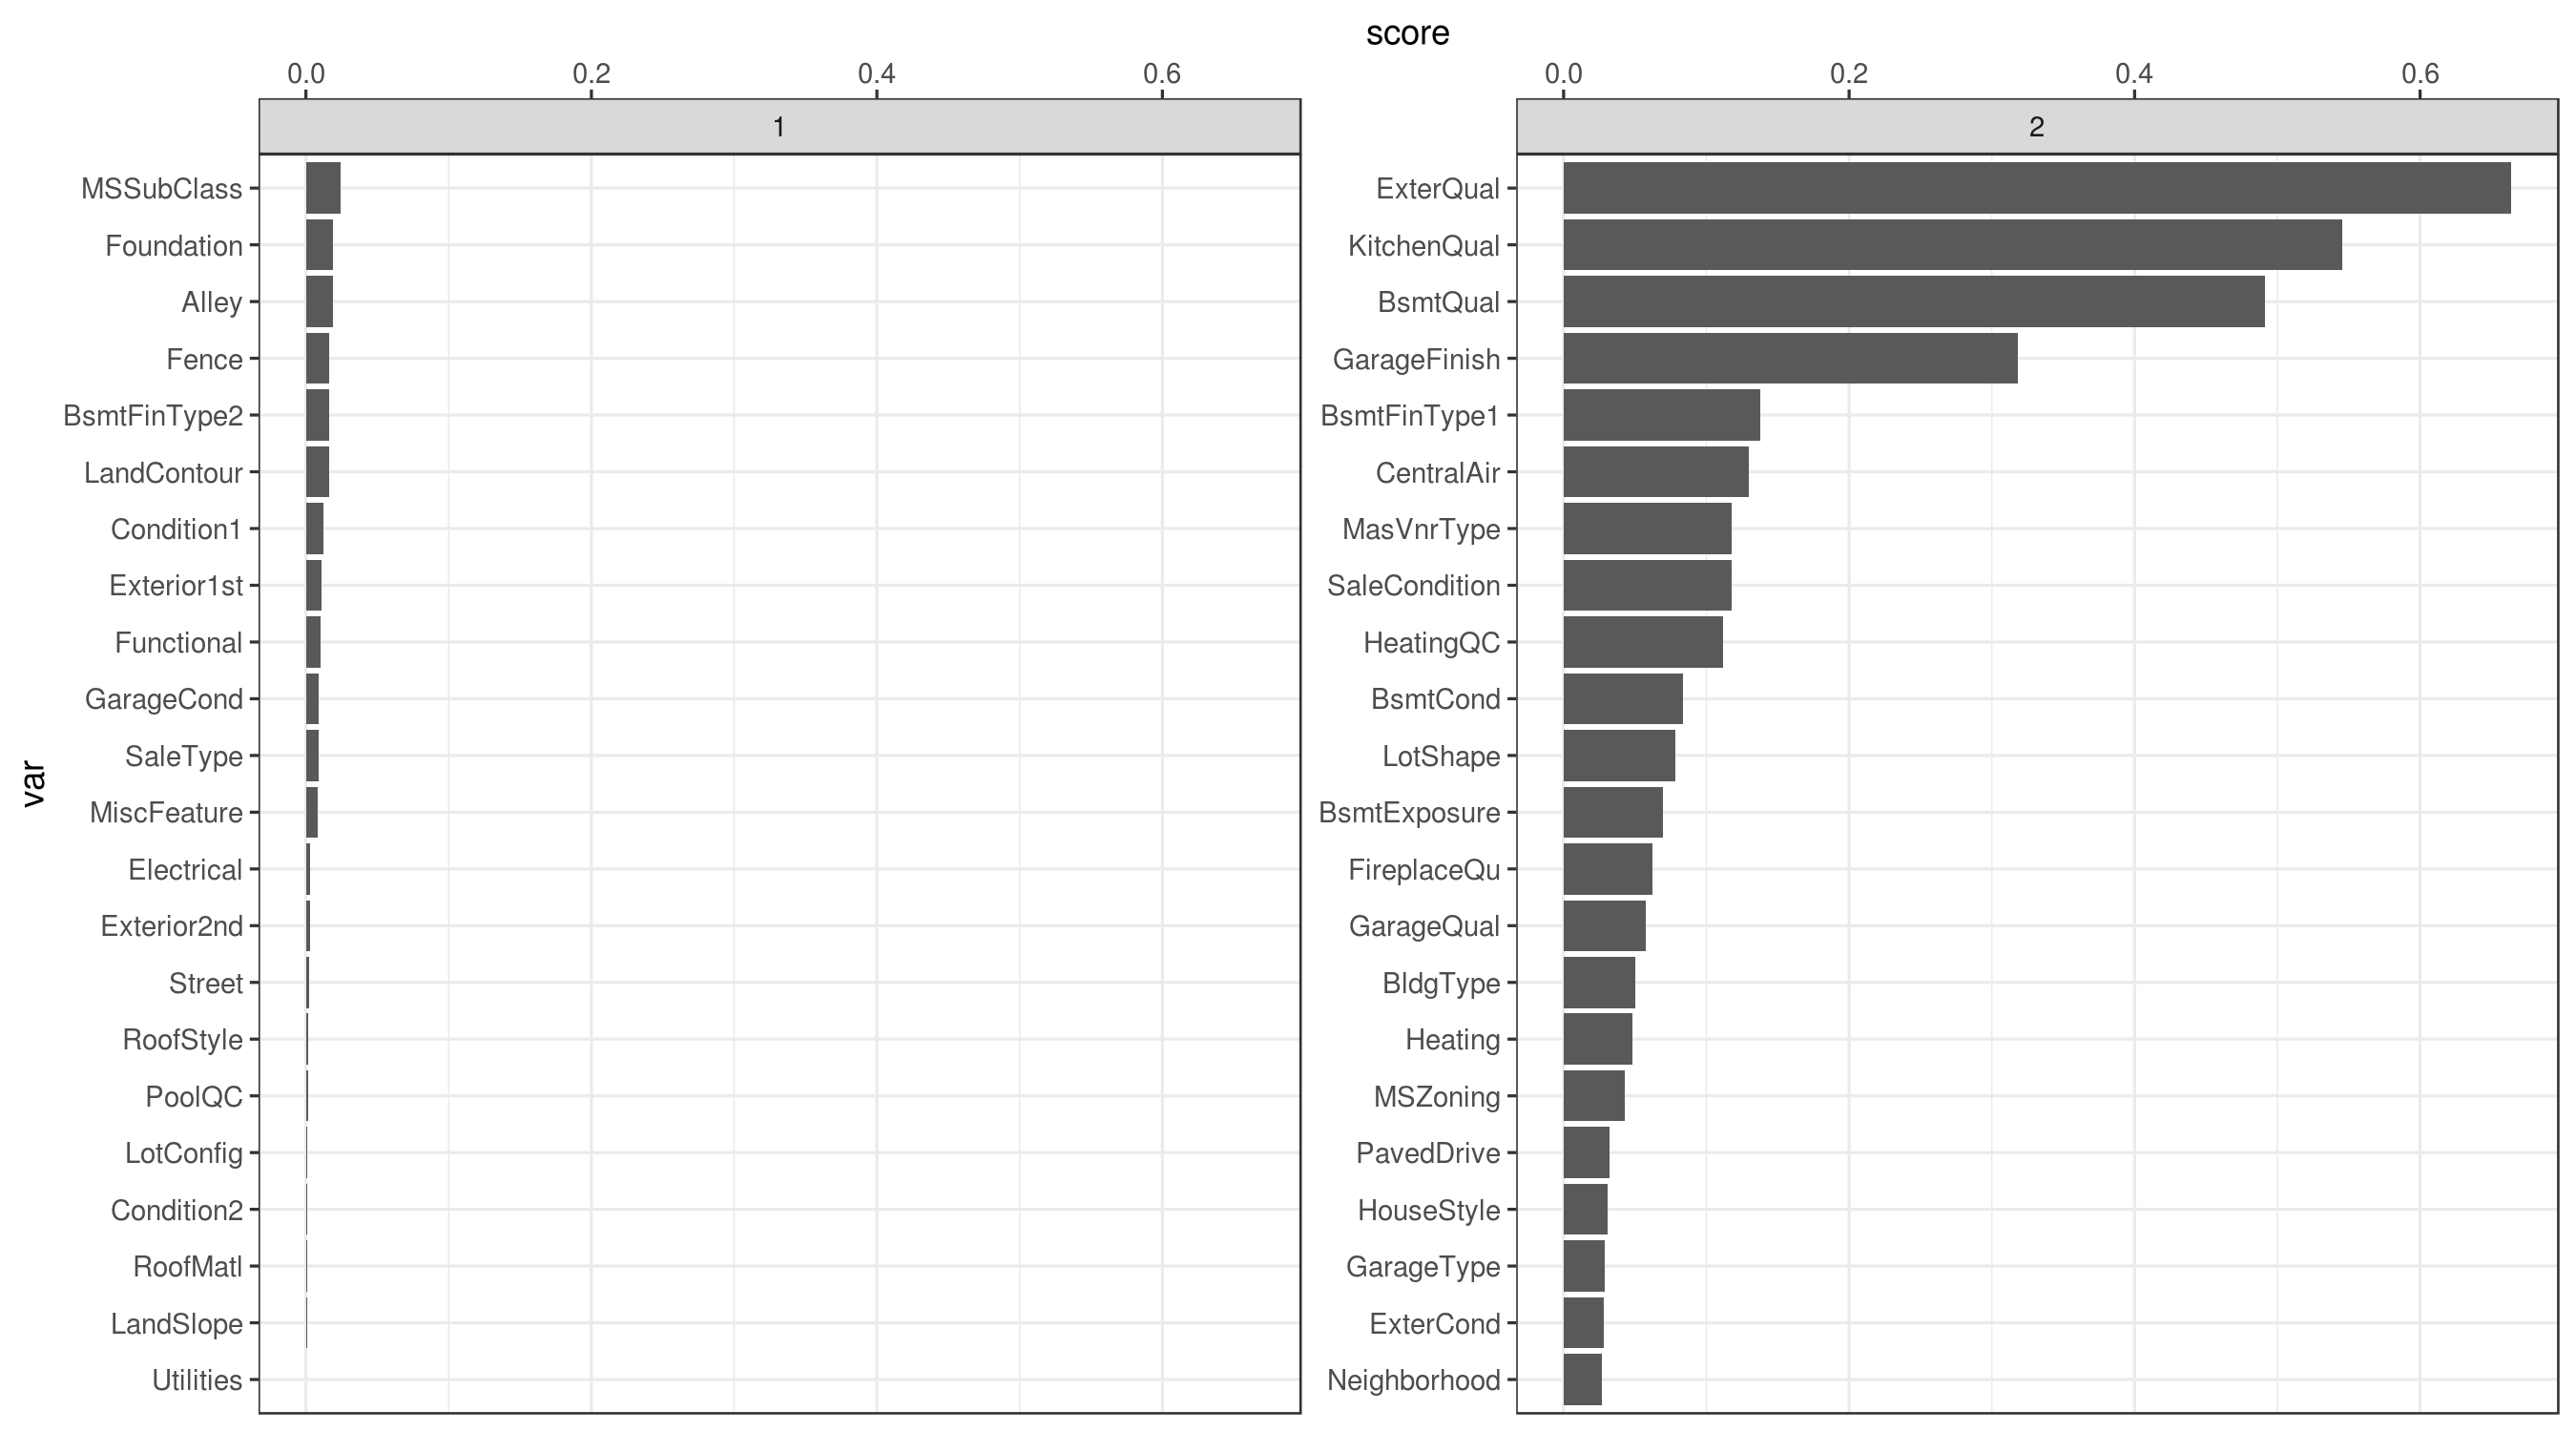

In [44]:
predictors_by_separation = (
    attr_sel.GroupsSeparation(
        categ_data.assign(price_log=lambda df: np.log(df['SalePrice'])).drop(columns=['SalePrice', 'Id']), 
        'price_log'
    )
    .arrange_vars()
    .assign(type="Categorical")
    .assign(
        var=lambda df: (
            df['var'].astype('category')
            .cat.reorder_categories(df['var'], ordered=True)
        ),
        basket=lambda df: (
            np.floor(2*(df.index / df.shape[0])) + 1
        )
    )
)

book.show_table(
    (predictors_by_separation.tail(), 'Large separation'),
    (predictors_by_separation.head(), 'Small separation'), 
)


with book.Plot(width=2700, height=1500, res=220) as plot:
    plot(
        gg2.ggplot(data=predictors_by_separation) +
        gg2.geom_bar(gg2.aes_string(x='var', y='score'), stat="identity") +
        gg2.facet_wrap(book.robjects.Formula('~basket'), nrow = 1, ncol = 2, scales="free_y") +
        gg2.coord_flip() +
        gg2.scale_y_continuous(position="top") +
        gg2.theme_bw() +
        gg2.theme(**{'legend.position': "bottom"}) 
    )

### Visualising separation by two opposite cases

In [66]:
# Helper function that orderes factor levels by SalePrice's mean value at that level.
# Otherwise ggplot will by default order levels lexicographically.
attr_sel.order_factor_by_target(
    categ_data.dropna(subset=['SalePrice'])[['ExterQual', 'SalePrice']], 
    factor_var='ExterQual', 
    target_var='SalePrice'
)['ExterQual'].dtype

CategoricalDtype(categories=['Fa', 'TA', 'Gd', 'Ex'], ordered=True)

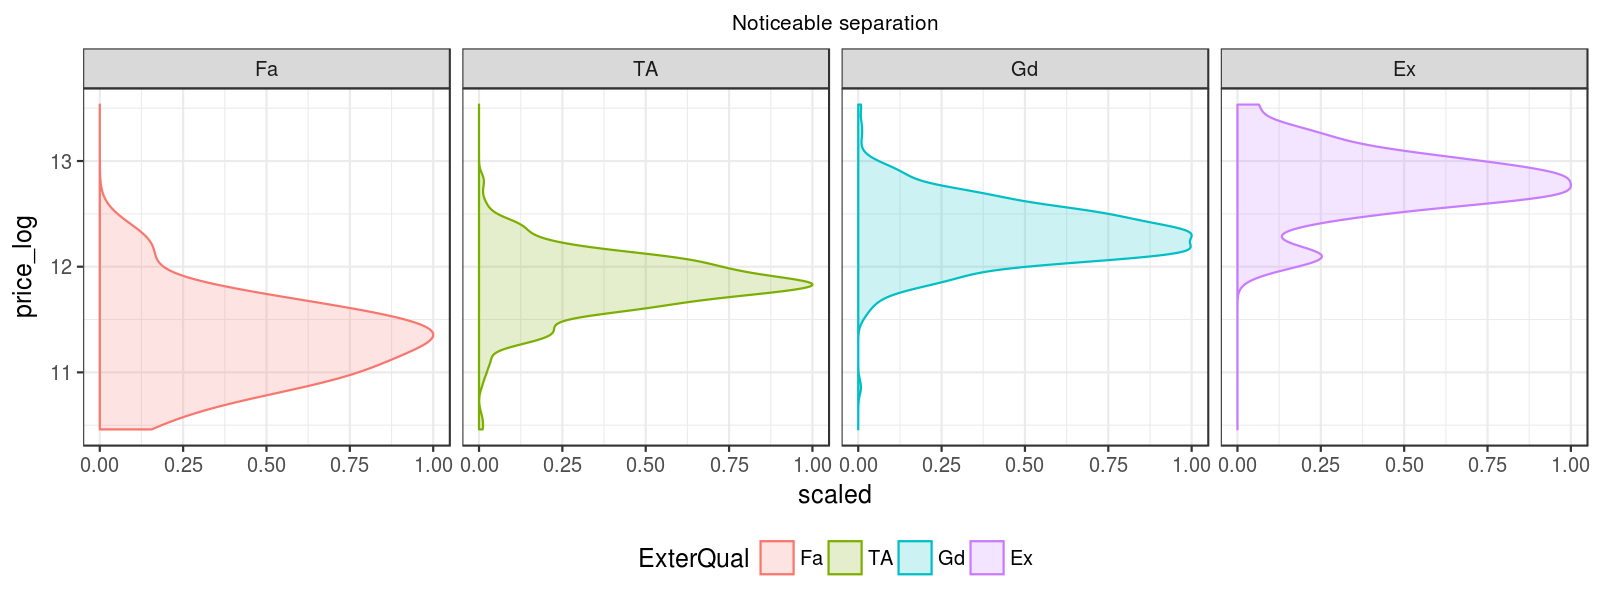

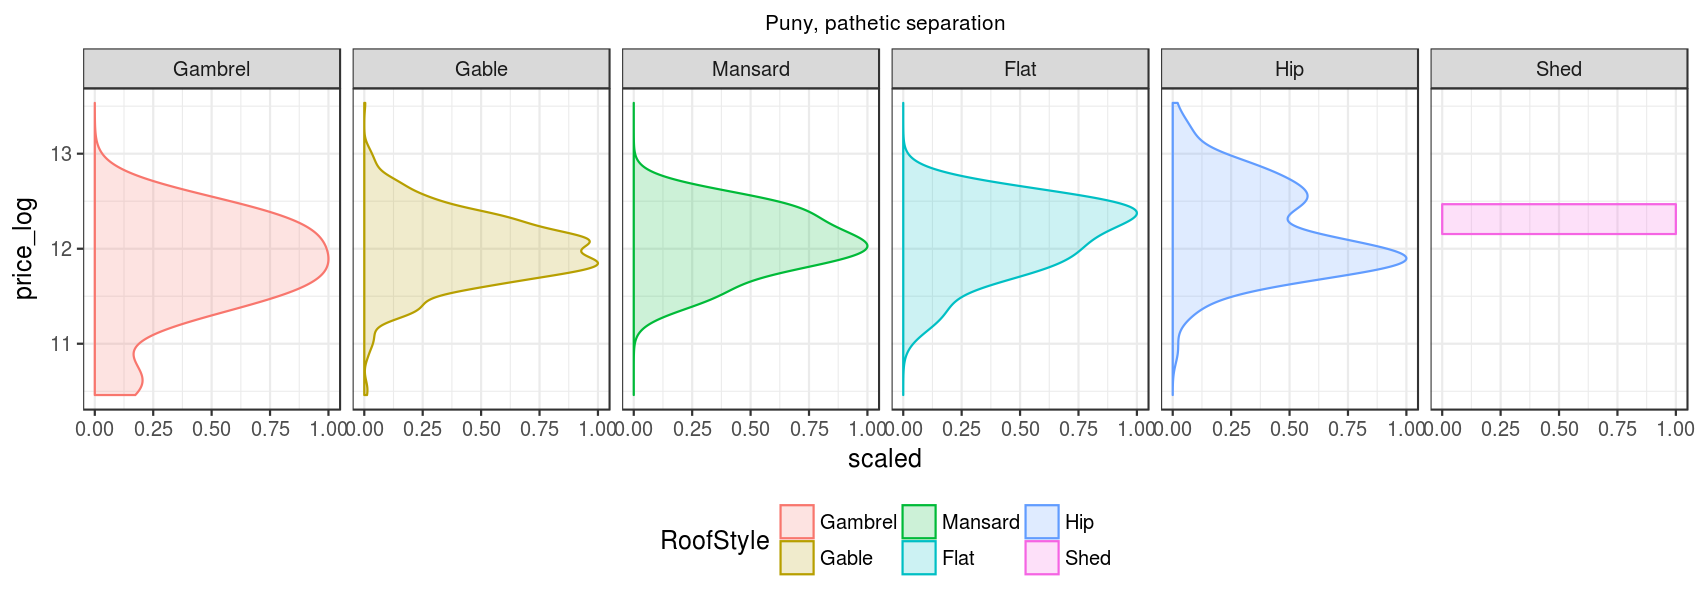

In [47]:
df = (
    categ_data
    .dropna(subset=['SalePrice'])
    [['ExterQual', 'RoofStyle', 'SalePrice']]
    .assign(price_log=lambda df: np.log(df['SalePrice']))
    .drop(columns=['SalePrice'])
)


with book.Plot(width=1600, height=600, res=150) as plot:
    plot(
        gg2.ggplot(
            attr_sel.order_factor_by_target(df, 
                factor_var='ExterQual', target_var='price_log')
        ) +
        gg2.aes_string(x='price_log', color='ExterQual') +
        gg2.geom_density(gg2.aes_string(y='..scaled..', fill='ExterQual'), alpha=0.2) +
        gg2.facet_wrap(book.robjects.Formula('~ ExterQual'), nrow=1) +
        gg2.coord_flip() +
        gg2.theme_bw() +
        gg2.theme(**{'legend.position': 'bottom', 'plot.title': gg2.element_text(hjust = 0.5)}) +
        gg2.labs(title = "Noticeable separation")
    ) 
    

with book.Plot(width=1700, height=600, res=150) as plot:
    plot(
        gg2.ggplot(
            attr_sel.order_factor_by_target(df, 
                factor_var='RoofStyle', target_var='price_log')
        ) +
        gg2.aes_string(x='price_log', color='RoofStyle') +
        gg2.geom_density(gg2.aes_string(y='..scaled..', fill='RoofStyle'), alpha=0.2) +
        gg2.facet_wrap(book.robjects.Formula('~ RoofStyle'), nrow=1) +
        gg2.coord_flip() +
        gg2.theme_bw() +
        gg2.theme(**{'legend.position': 'bottom', 'plot.title': gg2.element_text(hjust = 0.5)}) +
        gg2.labs(title = "Puny, pathetic separation")
    ) 

### Ordering factors by $R^2$ of $log(SalePrice) \sim factor$

In [27]:
# For consintency with R __missing__ coding is replaced to NaN. 
# That will make statsmodels to drop out NaN observations exactly like it is done in R.
categ_vars_by_r2 = attr_sel.arrange_vars_by_r2(
    categ_data.replace('__missing__', np.NaN), 
    'SalePrice'
)

numeric_vars_by_r2 = attr_sel.arrange_vars_by_r2(numeric_data, 'SalePrice')

# By Fisher statistics

For datailed comparison with R look at `learn/anova_separation` notebook.

In [32]:
df = (
    categ_data
    .assign(
        price_log = lambda df: np.log(df['SalePrice'])
    )
    .drop('SalePrice', 1)
)

anova = attr_sel.Anova(df, 'price_log')

q_table = anova.Q_table()
q_table.head()

# control
# should be close to zero
np.max((q_table['Q_total'] - (q_table['Q_within_groups'] + q_table['Q_of_groups'])))

,var,Q_of_groups,Q_total,Q_within_groups,num_levels,num_observ
0,Alley,6.433964,232.800659,226.366695,3.0,1460.0
1,BldgType,9.344708,232.800659,223.455951,5.0,1460.0
2,BsmtCond,20.169471,232.800659,212.631188,5.0,1460.0
3,BsmtExposure,33.195897,232.800659,199.604762,5.0,1460.0
4,BsmtFinType1,52.998896,232.800659,179.801763,7.0,1460.0


1.4779288903810084e-12

In [33]:
categ_vars_by_fisher = anova.arrange_vars()

In [34]:
categ_vars_by_fisher.head()

,var,F
44,Utilities,0.232689
35,MoSold,0.993740
28,LandSlope,1.083039
9,Condition2,2.527740
34,MiscFeature,3.621236


In [35]:
categ_vars_by_fisher.tail()

,var,F
7,CentralAir,205.666987
20,GarageFinish,298.769753
6,BsmtQual,300.392324
26,KitchenQual,393.320196
12,ExterQual,415.303357


# Discarding weak categorical variables

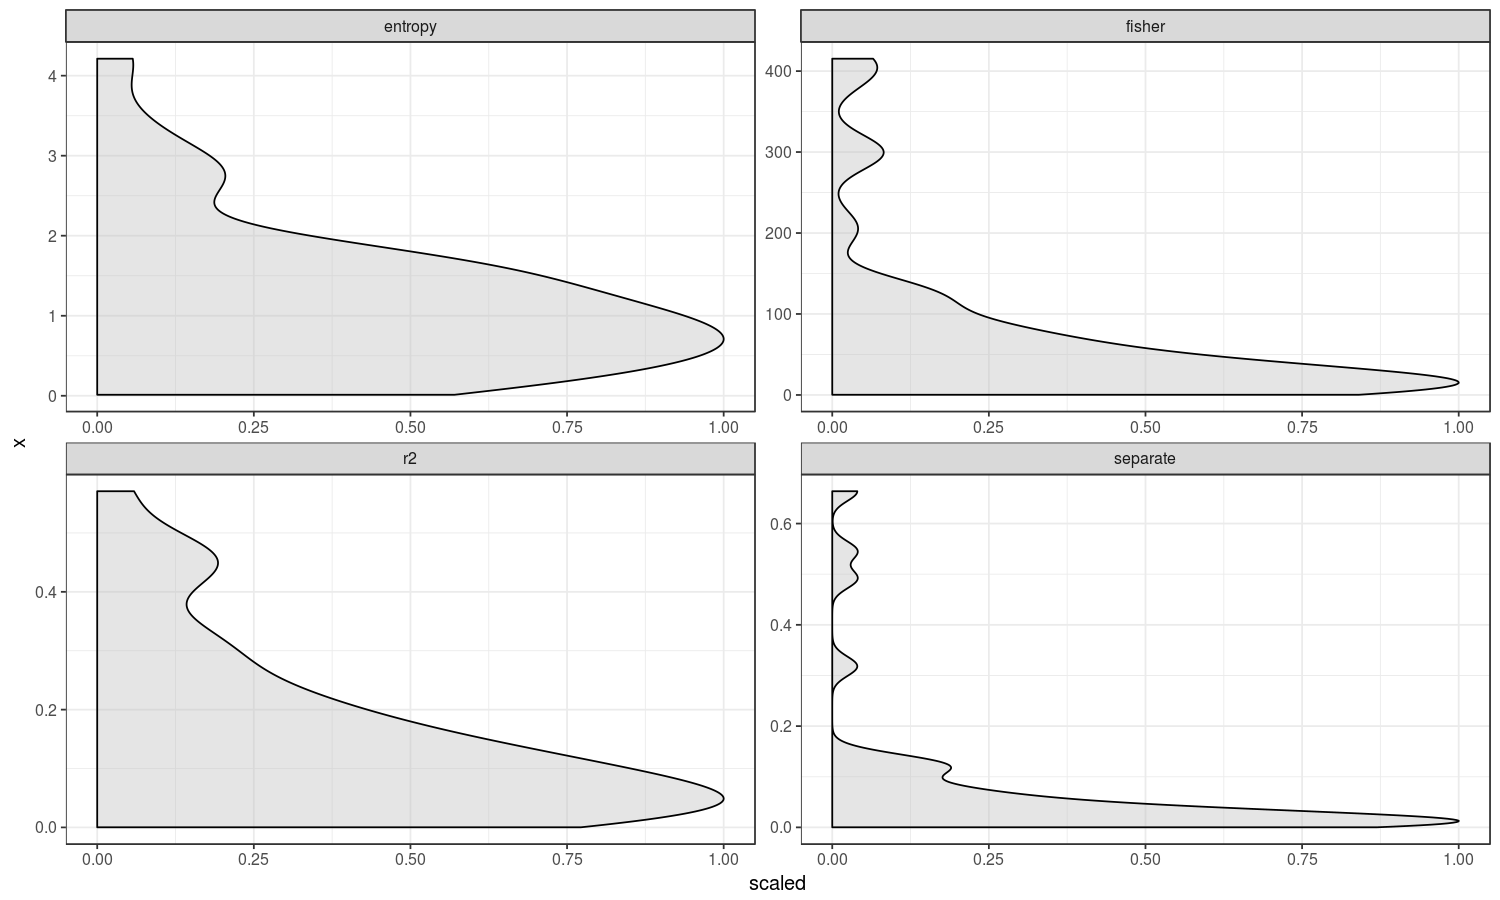

In [36]:
df = (
    categ_data
    .assign(
        price_log = lambda df: np.log(df['SalePrice'])
    )
    .drop('SalePrice', 1)
)

cat_by_entropy = attr_sel.arrange_vars_by_entropy(df.drop('price_log', 1))
cat_by_groups_separation = attr_sel.GroupsSeparation(df, 'price_log').arrange_vars()
cat_by_r2 = attr_sel.arrange_vars_by_r2(df.replace('__missing__', np.NaN), 'price_log')
cat_by_fisher = attr_sel.Anova(df, 'price_log').arrange_vars()

df_ggplot = pd.concat([
    cat_by_entropy.assign(method = 'entropy').rename(columns={'entropy': 'x'}),
    cat_by_groups_separation.assign(method = 'separate').rename(columns={'score': 'x'}),
    cat_by_r2.assign(method = 'r2').rename(columns={'r2': 'x'}),
    cat_by_fisher.assign(method = 'fisher').rename(columns={'F': 'x'}),
])

with Plot(width=1500, height=900, res=120) as plot:
    plot(
        ggplot2.ggplot(df_ggplot) +
        ggplot2.aes_string(x='x') +
        ggplot2.geom_density(ggplot2.aes_string(y='..scaled..'), alpha=0.4, fill='grey') +
        ggplot2.facet_wrap(robjects.Formula('~method'), nrow=2, ncol=2, scales = "free") +
        ggplot2.coord_flip() +
        ggplot2.theme_bw()
    ) 

In [37]:
x1 = cat_by_entropy.query('entropy < 1')['var']
x2 = cat_by_groups_separation.query('score < 0.2')['var']
x3 = cat_by_r2.query('r2 < 0.1')['var']
x4 = cat_by_fisher.query('F < 100')['var']

cat_virgin_vars = set.intersection(set(x1), set(x2), set(x3), set(x4))
cat_chad_vars = set(categ_data) - cat_virgin_vars

str(sorted(list(cat_virgin_vars)))
str(sorted(list(cat_chad_vars)))

"['BldgType', 'BsmtCond', 'BsmtFinType2', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'Functional', 'GarageCond', 'GarageQual', 'Heating', 'LandContour', 'LandSlope', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'Street', 'Utilities']"

"['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'CentralAir', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'GarageFinish', 'GarageType', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'PoolQC', 'SaleCondition', 'SalePrice', 'SaleType']"

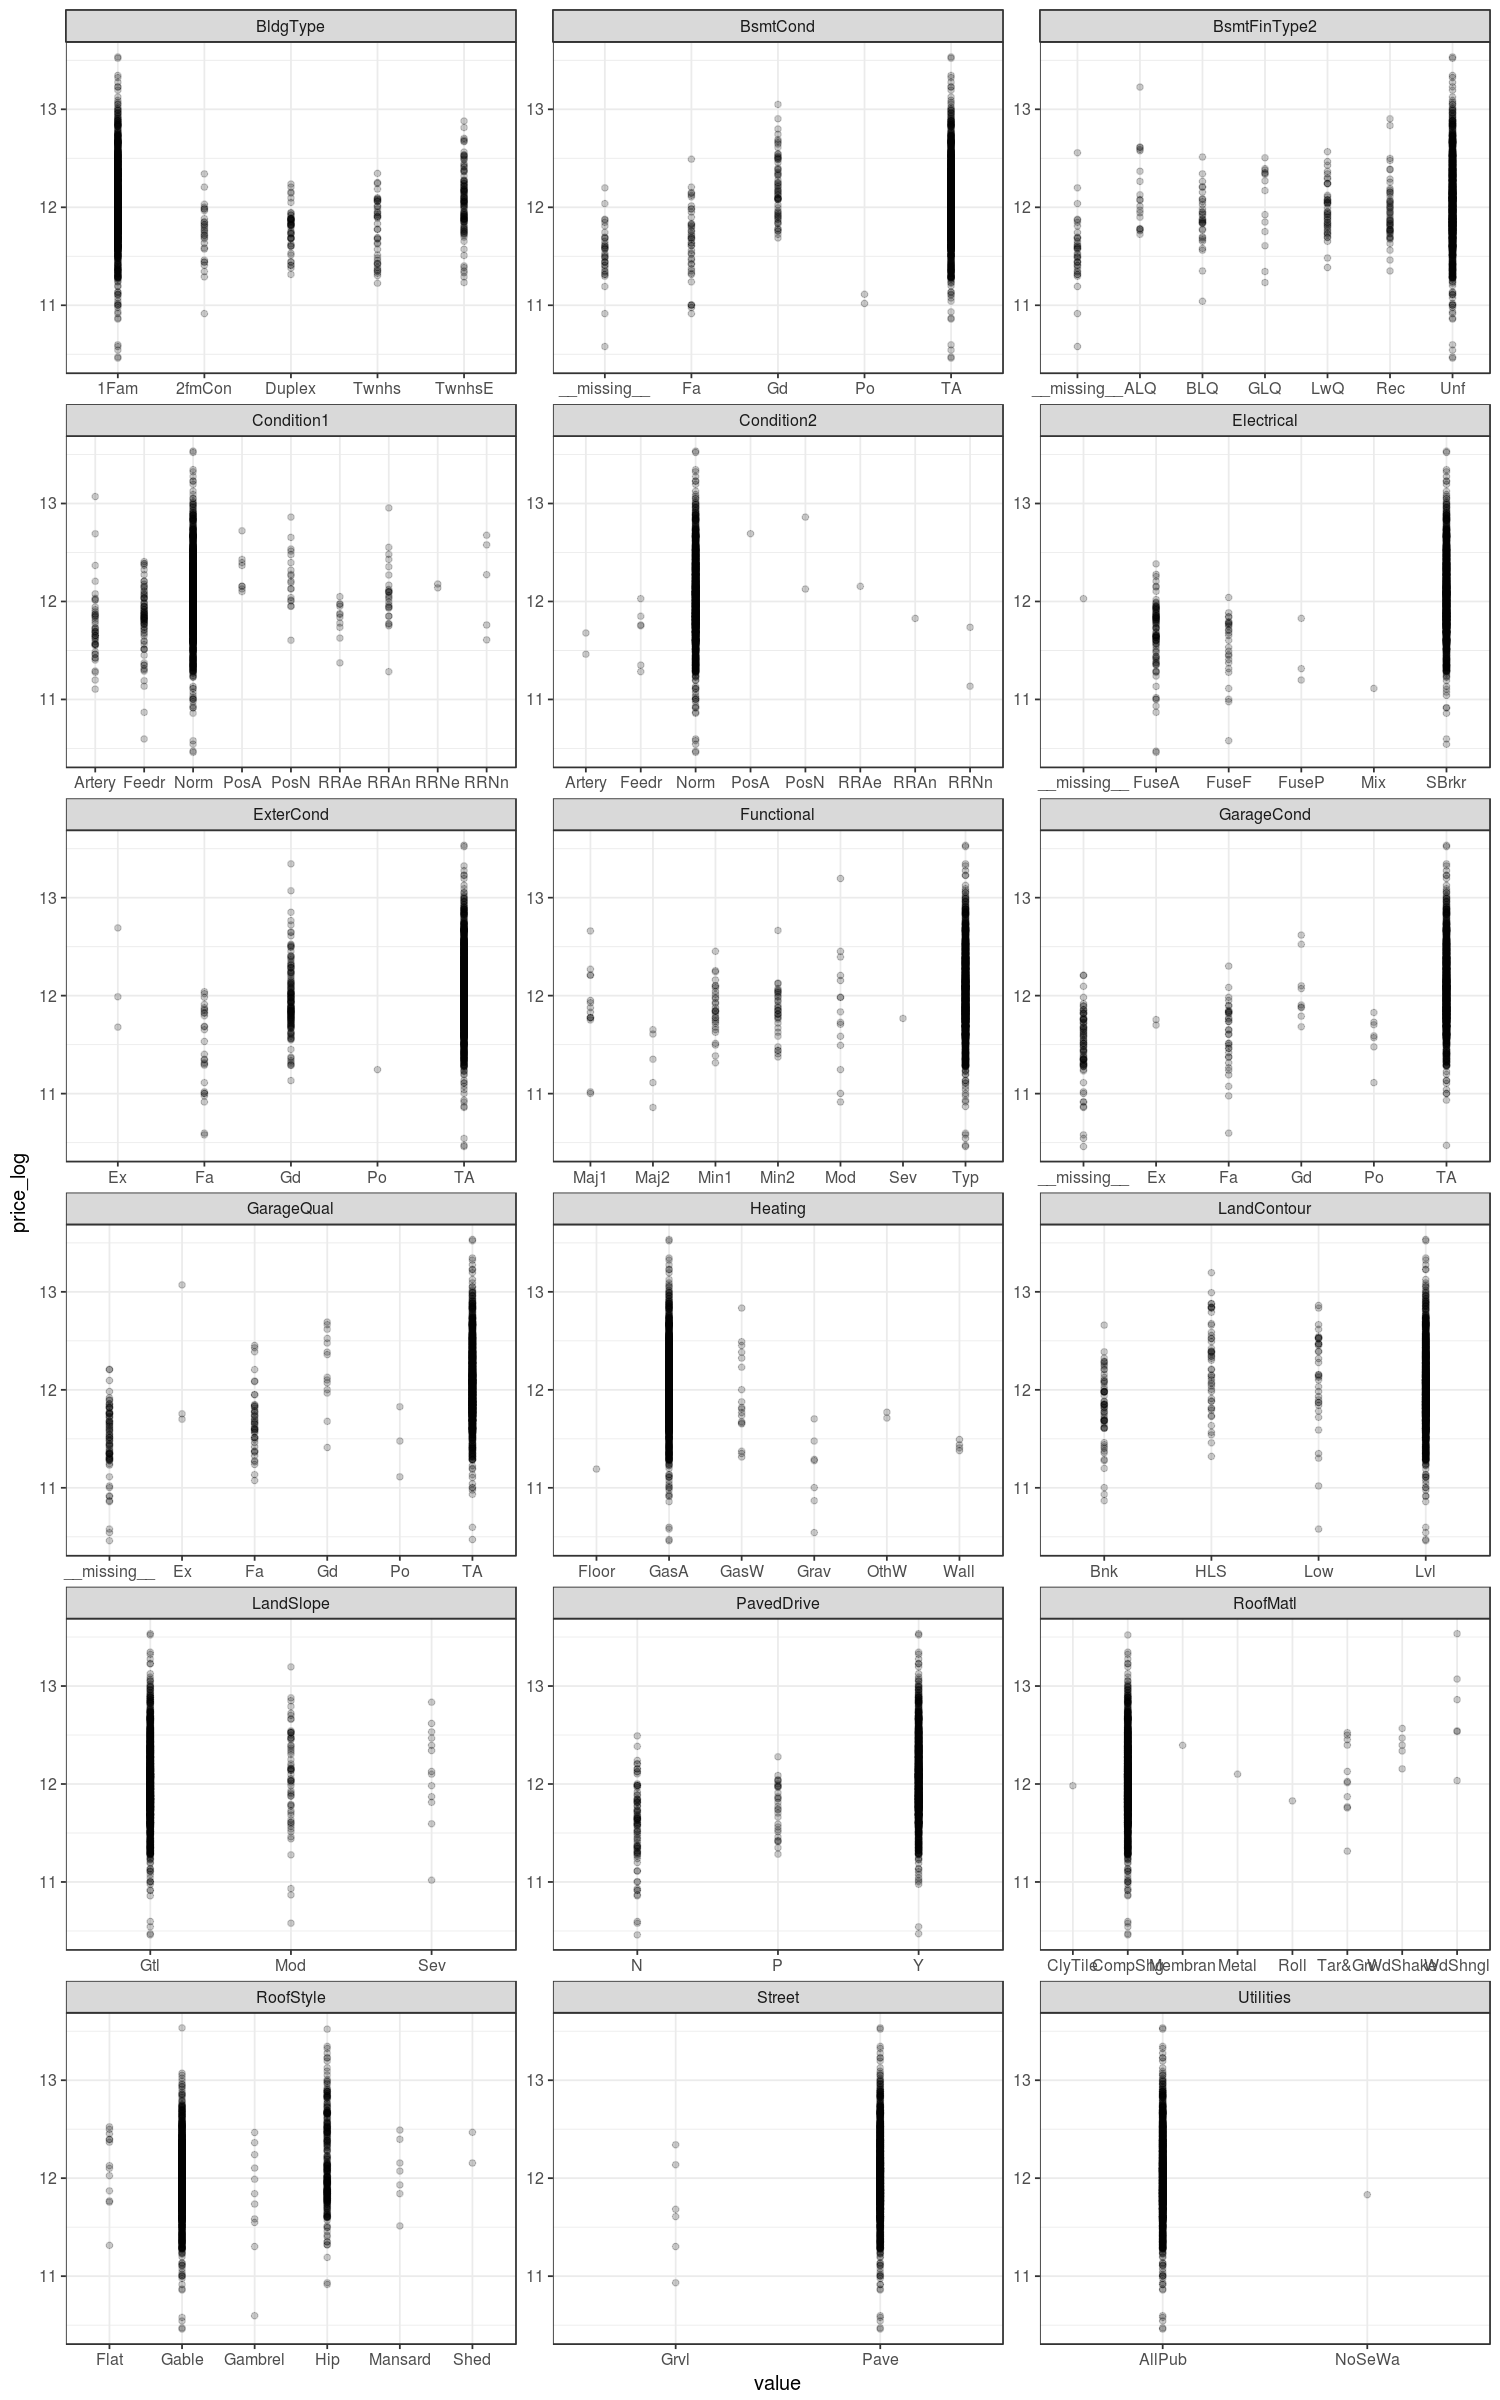

In [38]:
df = pd.melt(
    (
        categ_data
        .dropna(subset=['SalePrice'])
        .assign(price_log = lambda df: np.log(df['SalePrice']))
        [list(cat_virgin_vars | set(['price_log']))]
    ),
    id_vars=['price_log'],
    var_name='var', 
    value_name='value'
)

with Plot(width=1500, height=2400, res=120) as plot:
    plot(
        ggplot2.ggplot(df) +
        ggplot2.aes_string(x='value', y='price_log') +
        ggplot2.geom_point(alpha = 0.2) +
        ggplot2.facet_wrap(robjects.Formula('~var'), ncol=3, scale="free") +
        ggplot2.theme_bw()
    ) 

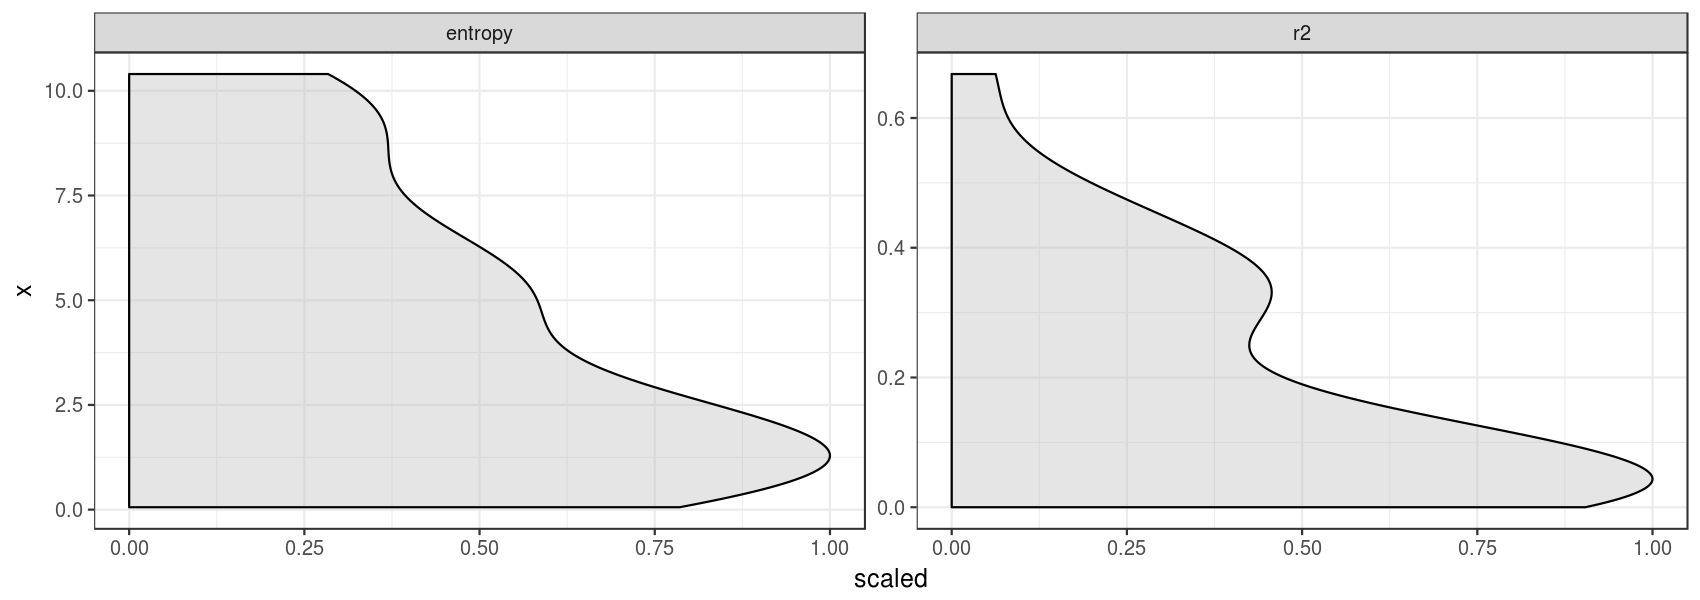

In [44]:
df = (
    numeric_data
    .assign(
        price_log = lambda df: np.log(df['SalePrice'])
    )
    .drop('SalePrice', 1)
)

num_by_entropy = attr_sel.arrange_vars_by_entropy(df)
num_by_r2 = attr_sel.arrange_vars_by_r2(df, 'price_log')

df_ggplot = pd.concat([
    num_by_entropy.assign(method = 'entropy').rename(columns={'entropy': 'x'}),
    num_by_r2.assign(method = 'r2').rename(columns={'r2': 'x'}),
])

with Plot(width=1700, height=600, res=150) as plot:
    plot(
        ggplot2.ggplot(df_ggplot) +
        ggplot2.aes_string(x='x') +
        ggplot2.geom_density(ggplot2.aes_string(y='..scaled..'), alpha=0.4, fill='grey') +
        ggplot2.facet_wrap(robjects.Formula('~method'), nrow=1, ncol=2, scales = "free") +
        ggplot2.coord_flip() +
        ggplot2.theme_bw()
    ) 

In [40]:
x1 = num_by_entropy.query('entropy < 2')['var']
x2 = num_by_r2.query('r2 < 0.1')['var']

num_virgin_vars = set(x1) & set(x2)
num_chad_vars = set(numeric_data) - num_virgin_vars

str(sorted(list(num_virgin_vars)))
str(sorted(list(num_chad_vars)))

"['3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'EnclosedPorch', 'HalfBath', 'KitchenAbvGr', 'LowQualFinSF', 'MiscVal', 'OverallCond', 'PoolArea', 'ScreenPorch']"

"['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallQual', 'SalePrice', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']"

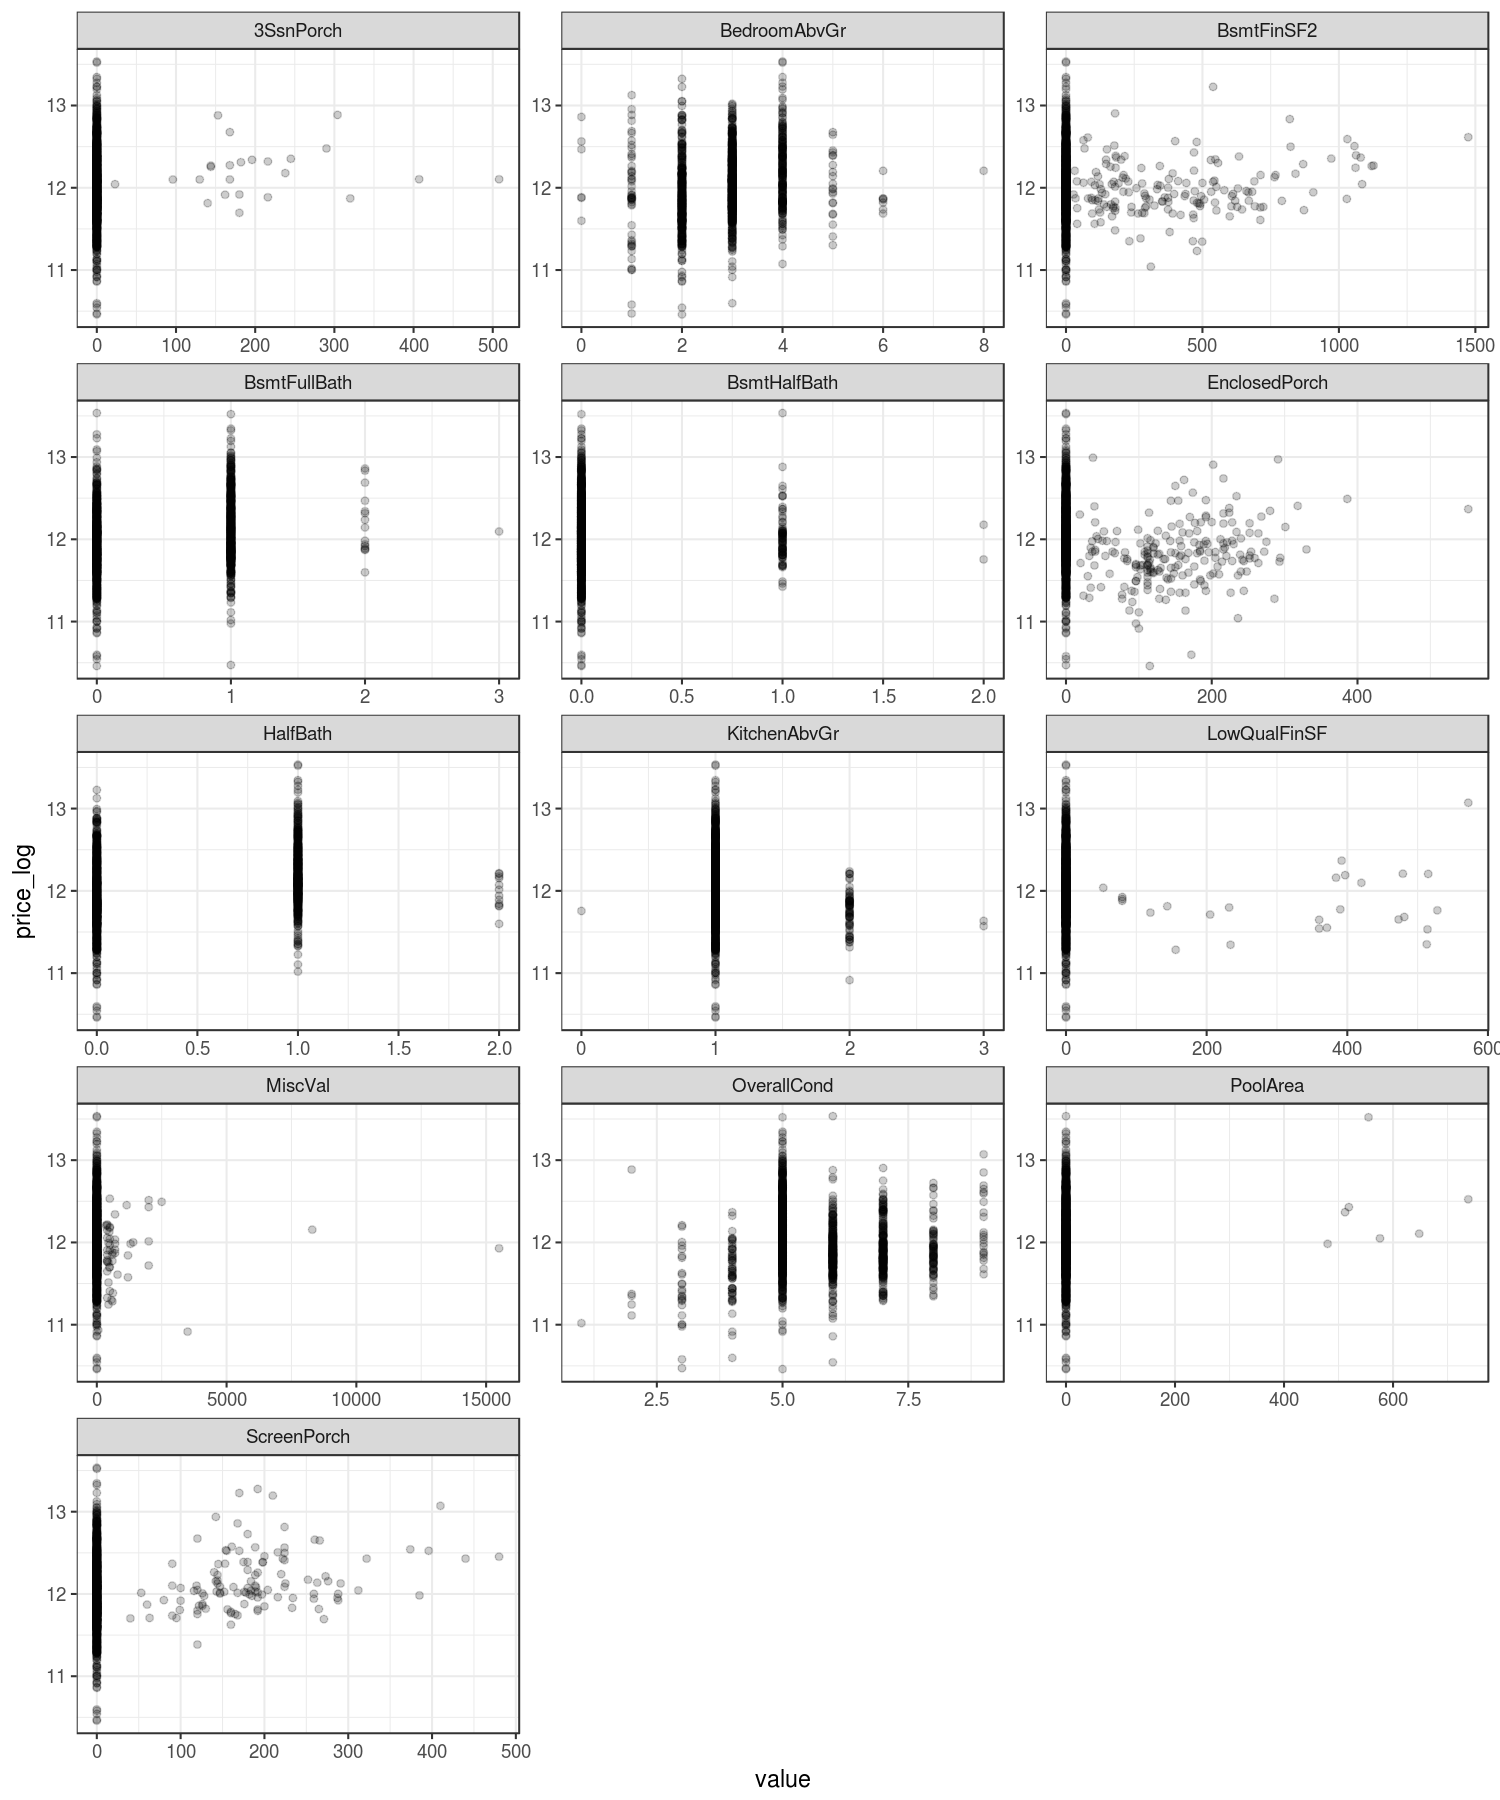

In [41]:
df = pd.melt(
    (
        numeric_data
        .dropna(subset=['SalePrice'])
        .assign(price_log = lambda df: np.log(df['SalePrice']))
        [list(num_virgin_vars | set(['price_log']))]
    ),
    id_vars=['price_log'],
    var_name='var', 
    value_name='value'
)

with Plot(width=1500, height=1800, res=140) as plot:
    plot(
        ggplot2.ggplot(df) +
        ggplot2.aes_string(x='value', y='price_log') +
        ggplot2.geom_point(alpha = 0.2) +
        ggplot2.facet_wrap(robjects.Formula('~var'), ncol=3, scale="free") +
        ggplot2.theme_bw()
    ) 